# MNIST for dummies 

Adapated from [TensorFlow tutorials](https://www.tensorflow.org/versions/r0.8/tutorials/mnist/beginners/index.html) 

MNIST is a simple computer vision dataset. It consists of images of handwritten digits like these:

![](https://www.tensorflow.org/versions/r0.8/images/MNIST.png)

It also includes **labels** for each image, telling us which digit it is. For example, the labels for the above images are 5, 0, 4, and 1.

We are going to start with a very simple model, called a **Softmax Regression**.


In [4]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## The MNIST Data

The MNIST data is hosted on [Yann LeCun's](http://yann.lecun.com/exdb/mnist/) website. 

We first download it and save it under `MNIST_data/`



In [5]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


The downloaded data is split into three parts:

* 55,000 data points of training data (`mnist.train`)
* 10,000 points of test data (`mnist.test`), 
* 5,000 points of validation data (`mnist.validation`).

This split is **very important**: it's essential in machine learning that we have separate data which we don't learn from so that we can make sure that what we've learned actually generalizes!

Every MNIST data point has two parts: 

* an image of a handwritten digit, and
* a corresponding label. 

We will call the images `xs` and the labels `ys`.

Both the training set and test set contain `xs` and `ys`. 
The training images are `mnist.train.images` and the train labels are `mnist.train.labels`.



Each image is 28 pixels by 28 pixels. We can interpret this as a big array of numbers:

![](https://www.tensorflow.org/versions/r0.8/images/MNIST-Matrix.png)

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.])

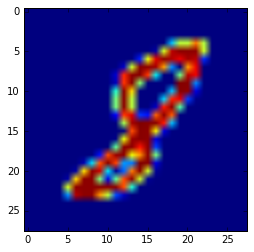

In [6]:
index=numpy.random.randint(55000)

imshow(reshape(mnist.train.images[index],[28, 28]))

mnist.train.labels[index]

## Model: Softmax Regressions

We want to be able to look at an image and give probabilities for it being each digit. For example, our model might look at a picture of a nine and be 80% sure it's a nine, but give a 5% chance to it being an eight (because of the top loop) and a bit of probability to all the others because it isn't sure.

This is a classic case where a softmax regression is a natural, simple model. If you want to assign probabilities to an object being one of several different things, softmax is the thing to do. 


A softmax regression has two steps: 

First we add up the evidence of our input being in certain classes, and then we convert that evidence into probabilities.

To tally up the evidence that a given image is in a particular class, we do a weighted sum of the pixel intensities. The weight is negative if that pixel having a high intensity is evidence against the image being in that class, and positive if it is evidence in favor.

The following diagram shows the weights one model learned for each of these classes. Red represents negative weights, while blue represents positive weight

![](https://www.tensorflow.org/versions/r0.8/images/softmax-weights.png)

Basically, we want to be able to say that some things are more likely independent of the input. The result is that the evidence for a class $i$ given an input $x$ is:

\begin{equation}
\text{evidence}_i = \sum_j W_{i,~j} x_j + b_i
\end{equation}


where $W_i$ is the weights and $b_i$ is the bias for class $i$, and $j$ is an index for 
summing over the pixels in our input image $x$. We then convert the evidence tallies 
into our predicted probabilities $y$
 using the **softmax** function:

$$
y = \text{softmax}(\text{evidence})
$$

Here softmax is serving as an **activation** or **link** function, shaping the output of our linear function into the form we want -- in this case, a probability distribution over 10 cases. You can think of it as converting tallies of evidence into probabilities of our input being in each class. It's defined as:
$$
\text{softmax}(x) = \text{normalize}(\exp(x))
$$
or
$$
\text{softmax}(x)_i = \frac{\exp(x_i)}{\sum_j \exp(x_j)}
$$

You can picture our softmax regression as looking something like the following, although with a lot more $x$'s. For each output, we compute a weighted sum of the $x$'s, add a bias, and then apply softmax.

![](https://www.tensorflow.org/versions/r0.8/images/softmax-regression-scalargraph.png)

or as an equation

![](https://www.tensorflow.org/versions/r0.8/images/softmax-regression-scalarequation.png)

We can turn it into a matrix multiplication and vector addition. 

![](https://www.tensorflow.org/versions/r0.8/images/softmax-regression-vectorequation.png)

$$
y = \text{softmax}(Wx + b)
$$




In [7]:
x = tf.placeholder(tf.float32, [None, 784])
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))
y = tf.nn.softmax(tf.matmul(x, W) + b)
y_ = tf.placeholder(tf.float32, [None, 10])

# Training

In order to train our model, we need to define what it means for the model to be good. Well, actually, in machine learning we typically define what it means for a model to be bad, called the **cost** or **loss**, and then try to minimize how bad it is. 

One very common cost function is **cross-entropy.**  It's defined:

$$
H_{y'}(y) = -\sum_i y'_i \log(y_i)
$$

Where $y$ is our predicted probability distribution, and $y'$ is the true distribution. In some rough sense, the cross-entropy is measuring how inefficient our predictions are for describing the truth. 

In [8]:
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))

TensorFlow knows the entire graph of the computations, it can automatically use the **backpropagation algorithm** to efficiently determine how the variables affect the cost to minimize. 

It can apply your choice of **optimization algorithm** to modify the variables and reduce the cost.
In this case, we will use the **Gradient Descent** as our optimizer

Repeat
$$    
W_j = W_j - \lambda \frac{\partial F(W_j)}{\partial W_j}
$$
unitl convergence.

$\lambda$ is the ** learning rate**.

![](http://blog.datumbox.com/wp-content/uploads/2013/10/gradient-descent.png)







In [18]:
train_step = tf.train.GradientDescentOptimizer(0.13).minimize(cross_entropy)

Let us initialize the variables we created:

In [19]:
init = tf.initialize_all_variables()


We launch the model in a `Session`, and run the operation that initializes the variables:

In [20]:
sess = tf.Session()
sess.run(init)

Let's train the model 1000 times. 

Each step of the loop, we get a "batch" of one hundred random data points from our training set. We run `train_step` feeding in the batches data to replace the `placeholders`.

In [21]:
for i in range(1000):
  batch_xs, batch_ys = mnist.train.next_batch(100)
  sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

## Evaluating Our Model

First we need to figure out where we predicted the correct label. `tf.argmax` is an extremely useful function which gives you the index of the highest entry in a tensor along some axis. 

For example, `tf.argmax(y,1)` is the label our model thinks is most likely for each input, while `tf.argmax(y_,1)` is the correct label. We can use `tf.equal` to check if our prediction matches the truth.



In [22]:
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))


That gives us a list of booleans. To determine what fraction are correct, we cast to floating point numbers and then take the mean. For example, `[True, False, True, True]` would become `[1,0,1,1]` which would become `0.75`.

In [23]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


We ask for our accuracy on our test data.

In [24]:
print(sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

0.9128
